# Sieci wielowarstwowe c.d.
### Zadania
1. Jaką funkcję straty oraz parametry warstwy wyjściowej (liczba neuronów, funkcja aktywacji) należy zastosować dla następujących zadań?
    - Klasyfikacja, 2 klasy
    - Klasyfikacja, >2 klasy
    - Regresja
2. Podaj wymiary wejść/wyjść każdej warstwy oraz sumaryczną liczbę parametrów poniższych sieci.
    - Sieć 1:
        - Wejście (16)
        - Warstwa 1 (32 neurony)
        - Warstwa 2 (16 neuronów)
        - Warstwa wyjściowa (10 neuronów)
    - Sieć 2:
        - Wejście (64)
        - Warstwa 1 (16 neurony)
        - Warstwa 2 (8 neuronów)
        - Warstwa wyjściowa (1 neuron)
3. Klasyfikuj zbiór Reuters za pomocą sieci wielowarstwowych.
    - Dobierz odpowiednie parmanetry warstwy wyjściowej i funkcję straty.
    - Testuj sieci o różnych architekturach i rozmiarach. Stwórz co najmniej jedną sieć o zbyt małej złożoności i jedną o zbyt dużej złożoności.
    - Dla trenowanych modeli stwórz wykres funkcji straty i dokładności dla danych treningowych i walidacyjnych.
    - Użyj zbioru testowego do ewaluacji wybranego modelu.

In [2]:
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils.class_weight import compute_class_weight



(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)

mlb = MultiLabelBinarizer()
mlb.fit(list(train_data) + list(test_data))
X_train_full = mlb.transform(train_data)
y_train_full = train_labels
X_test = mlb.transform(test_data)
y_test = test_labels

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=1)

# - - - - - - - -  - - - - - - - - MOJA CZĘŚĆ - - - - - - - -- - - - - - - - -- 

# --- Ustalanie liczby klas i wymiaru wejścia ---
num_classes = int(np.max(y_train_full)) + 1
input_dim = X_train.shape[1]

# --- Budowa modelu MLP ---
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")  # warstwa wyjściowa
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",   # funkcja straty dla klasyfikacji wieloklasowej
    metrics=["accuracy"]
)

# --- Trenowanie ---
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=512,
    callbacks=[early_stop],
)

# --- Ewaluacja na zbiorze testowym ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.4160 - loss: 2.6729 - val_accuracy: 0.6221 - val_loss: 1.7330
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.6747 - loss: 1.4684 - val_accuracy: 0.6934 - val_loss: 1.3497
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7521 - loss: 1.0566 - val_accuracy: 0.7301 - val_loss: 1.1787
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8219 - loss: 0.7728 - val_accuracy: 0.7624 - val_loss: 1.1070
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8706 - loss: 0.5567 - val_accuracy: 0.7685 - val_loss: 1.1128
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9098 - loss: 0.3874 - val_accuracy: 0.7752 - val_loss: 1.1607
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9328 - loss: 0.2795 - val_accuracy: 0.7752 - val_loss: 1.2252
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9521 - loss: 0.2203 - val_accuracy: 0.7824

In [3]:

# Wspólne callbacki (patience różne dla demonstracji):
early_small = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
early_mid   = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
early_big   = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
# =========================
# 1) MODEL ZA MAŁY (UNDERFITTING)
# =========================
tf.random.set_seed(123)
model_small = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")  # wyjście + softmax
])

model_small.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_small = model_small.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=40,
    batch_size=512,
    callbacks=[early_small],
    verbose=2
)

small_loss, small_acc = model_small.evaluate(X_test, y_test, verbose=0)
print(f"[SMALL] Test loss: {small_loss:.4f} | Test acc: {small_acc:.4f}")

# =========================
# 2) MODEL „W SAM RAZ” (DOBRY PUNKT WYJŚCIA)
# =========================
tf.random.set_seed(123)
model_mid = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(256, activation="relu"),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_mid.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_mid = model_mid.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=40,
    batch_size=512,
    callbacks=[early_mid],
    verbose=2
)

mid_loss, mid_acc = model_mid.evaluate(X_test, y_test, verbose=0)
print(f"[MID]   Test loss: {mid_loss:.4f} | Test acc: {mid_acc:.4f}")

# =========================
# 3) MODEL ZA DUŻY (OVERFITTING)
# =========================
tf.random.set_seed(123)
model_big = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    # dużo neuronów i głębsza sieć -> duża pojemność, ryzyko przeuczenia
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"),
    # minimalny dropout, żeby specjalnie NIE chronić przed overfittingiem
    # tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_big.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_big = model_big.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=60,
    batch_size=256,   # mniejsza paczka, więcej aktualizacji, często szybciej „zapamiętuje” trening
    callbacks=[early_big],
    verbose=2
)

big_loss, big_acc = model_big.evaluate(X_test, y_test, verbose=0)
print(f"[BIG]   Test loss: {big_loss:.4f} | Test acc: {big_acc:.4f}")

# =========================
# Podsumowanie wyników
# =========================
print("\n=== PODSUMOWANIE ===")
print(f"Underfitting  (SMALL): acc={small_acc:.4f}")
print(f"Baseline      (MID)  : acc={mid_acc:.4f}")
print(f"Overfitting   (BIG)  : acc={big_acc:.4f}")


Epoch 1/40
15/15 - 2s - 144ms/step - accuracy: 0.4515 - loss: 3.4381 - val_accuracy: 0.5576 - val_loss: 2.9018
Epoch 2/40
15/15 - 0s - 31ms/step - accuracy: 0.5829 - loss: 2.5149 - val_accuracy: 0.5938 - val_loss: 2.1975
Epoch 3/40
15/15 - 0s - 32ms/step - accuracy: 0.6356 - loss: 1.8666 - val_accuracy: 0.6466 - val_loss: 1.7632
Epoch 4/40
15/15 - 0s - 30ms/step - accuracy: 0.6992 - loss: 1.4621 - val_accuracy: 0.6811 - val_loss: 1.5084
Epoch 5/40
15/15 - 0s - 27ms/step - accuracy: 0.7464 - loss: 1.2021 - val_accuracy: 0.7017 - val_loss: 1.3547
Epoch 6/40
15/15 - 0s - 27ms/step - accuracy: 0.7784 - loss: 1.0279 - val_accuracy: 0.7184 - val_loss: 1.2577
Epoch 7/40
15/15 - 0s - 25ms/step - accuracy: 0.8093 - loss: 0.8984 - val_accuracy: 0.7329 - val_loss: 1.1916
Epoch 8/40
15/15 - 0s - 25ms/step - accuracy: 0.8363 - loss: 0.7926 - val_accuracy: 0.7513 - val_loss: 1.1401
Epoch 9/40
15/15 - 0s - 24ms/step - accuracy: 0.8565 - loss: 0.7000 - val_accuracy: 0.7585 - val_loss: 1.0990
Epoch 10/

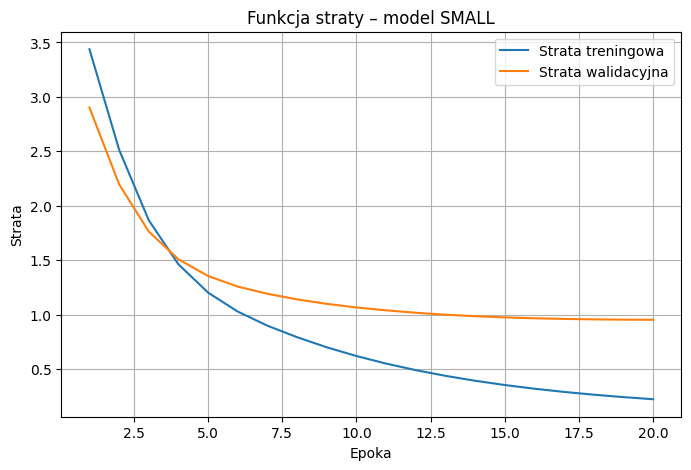

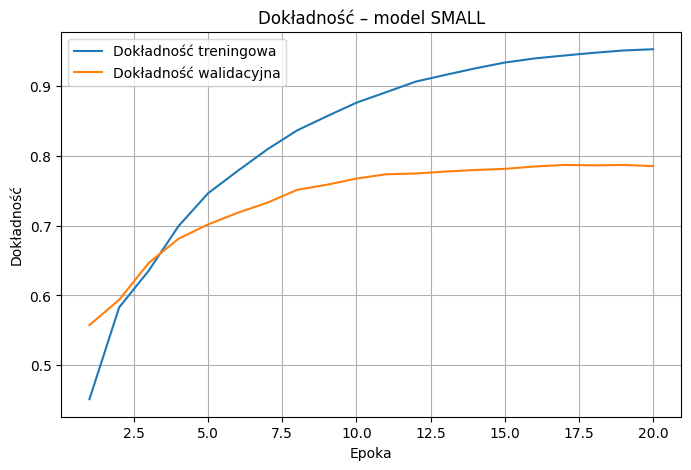

In [4]:
import matplotlib.pyplot as plt

# --- Dane z historii treningu ---
train_loss = hist_small.history["loss"]
val_loss = hist_small.history["val_loss"]
train_acc = hist_small.history["accuracy"]
val_acc = hist_small.history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

# --- Wykres STRATY ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Strata treningowa")
plt.plot(epochs, val_loss, label="Strata walidacyjna")
plt.title("Funkcja straty – model SMALL")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.grid(True)
plt.show()

# --- Wykres DOKŁADNOŚCI ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Dokładność treningowa")
plt.plot(epochs, val_acc, label="Dokładność walidacyjna")
plt.title("Dokładność – model SMALL")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.legend()
plt.grid(True)
plt.show()


4. Stwórz sieć neuronową dla predykcji cen domów ze zbioru California Housing.
    - Dane można wczytać metodą [`tf.keras.datasets.california_housing.load_data()`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/california_housing/load_data). Dane należy podzielić na zbiór treningowy, walidacyjny i testowy, a następnie standaryzować.
    - Dobierz odpowiednie parmanetry warstwy wyjściowej i funkcję straty.
    - Dobierz odpowiednią architekturę sieci. Stwórz wykres przedstawiający błąd dla danych treningowych i walidacyjnych.
    - Użyj zbioru testowego do ewaluacji modelu.

In [13]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- 1. Wczytanie danych ---
(X_full, y_full), _ = tf.keras.datasets.california_housing.load_data()

# --- 2. Podział na zbiory ---
# zbiór testowy (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# walidacyjny z treningowego (20% z treningu)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# --- 3. Standaryzacja cech ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

# --- 4. Sprawdzenie ---
print("Średnia po standaryzacji (train):", np.mean(X_train_scaled, axis=0))
print("Odchylenie standardowe (train):", np.std(X_train_scaled, axis=0))

df_train_scaled = pd.DataFrame(X_train_scaled)
df_train_scaled.head()

Średnia po standaryzacji (train): [ 2.73571055e-09 -5.82678128e-09  1.69219199e-08  1.10415534e-08
  1.47241863e-08 -5.31348299e-09  1.16923422e-08 -1.45528514e-08]
Odchylenie standardowe (train): [1.0000008  1.0000001  1.000003   0.99999964 0.99999875 1.0000004
 0.9999989  0.9999995 ]


,0,1,2,3,4,5,6,7
0,-1.338932,1.005763,1.856892,-0.508968,-0.516807,-0.538028,-0.614458,-0.219633
1,-1.383815,2.203523,-1.336497,0.561000,0.361809,0.527447,0.479915,-0.654993
2,-1.059651,0.625297,-0.458315,-0.646345,-0.673957,-0.662319,-0.698038,0.680043
3,-1.313995,1.160766,-1.895340,3.197429,2.838124,2.879958,2.822762,0.328093
4,0.930232,-0.736860,-1.735671,-0.875459,-0.933494,-0.892887,-0.959225,-0.508347


In [14]:
import tensorflow as tf

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)  # liniowa regresja
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",  # albo: tf.keras.losses.Huber(), "mae"
    metrics=["mae", tf.keras.metrics.RootMeanSquaredError(name="rmse")]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=100, batch_size=256,
    callbacks=[early], verbose=2
)

test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"TEST -> loss(MSE)={test_loss:.4f} | MAE={test_mae:.4f} | RMSE={test_rmse:.4f}")


Epoch 1/100
42/42 - 2s - 48ms/step - loss: 56099205120.0000 - mae: 206911.9062 - rmse: 236852.7031 - val_loss: 56595873792.0000 - val_mae: 207223.4062 - val_rmse: 237898.8750
Epoch 2/100
42/42 - 0s - 6ms/step - loss: 56092450816.0000 - mae: 206896.1094 - rmse: 236838.4531 - val_loss: 56582578176.0000 - val_mae: 207193.0781 - val_rmse: 237870.9219
Epoch 3/100
42/42 - 0s - 6ms/step - loss: 56069533696.0000 - mae: 206843.9375 - rmse: 236790.0625 - val_loss: 56544337920.0000 - val_mae: 207107.6562 - val_rmse: 237790.5312
Epoch 4/100
42/42 - 0s - 6ms/step - loss: 56014118912.0000 - mae: 206719.7656 - rmse: 236673.0156 - val_loss: 56462708736.0000 - val_mae: 206928.0312 - val_rmse: 237618.8281
Epoch 5/100
42/42 - 0s - 6ms/step - loss: 55907971072.0000 - mae: 206484.5625 - rmse: 236448.6719 - val_loss: 56318910464.0000 - val_mae: 206613.9688 - val_rmse: 237316.0625
Epoch 6/100
42/42 - 0s - 6ms/step - loss: 55733297152.0000 - mae: 206099.4531 - rmse: 236079.0000 - val_loss: 56095084544.0000 - 

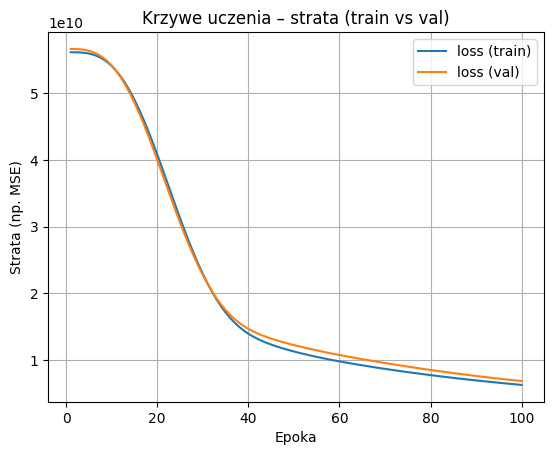

In [15]:
import matplotlib.pyplot as plt
#Wykres błędu (loss) dla treningu i walidacji
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]
epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, label="loss (train)")
plt.plot(epochs, val_loss,   label="loss (val)")
plt.xlabel("Epoka")
plt.ylabel("Strata (np. MSE)")
plt.title("Krzywe uczenia – strata (train vs val)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.metrics import r2_score

test_mse, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred = model.predict(X_test_scaled, verbose=0).ravel()
r2 = r2_score(y_test, y_pred)

print(f"TEST: MSE={test_mse:.4f} | RMSE={test_rmse:.4f} | MAE={test_mae:.4f} | R^2={r2:.4f}")


TEST: MSE=6635624448.0000 | RMSE=81459.3438 | MAE=58674.4414 | R^2=0.4959
